In [7]:
import math, torch
import numpy as np
from torch import nn, Tensor
import torch.nn.functional as F
# from torch.nn.modules.transformer import TransformerEncoderLayer
from Components import *

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [9]:
# Get a noisy sin wave
DATA_SIZE = 1000
x = np.sin(np.linspace(0, 10, DATA_SIZE))
x = x + np.random.normal(0, 0.05, DATA_SIZE)

# Create a dataset
seq_len = 200
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])

# Setup data loaders for batch
# train_dataset = TensorDataset(X, Y)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [10]:
# Positional Encoding - https://pytorch.org/tutorials/beginner/transformer_tutorial.html
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model: int, seq_len: int = 5000, dropout: float = 0.1):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)
#         position = torch.arange(seq_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(seq_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)
#     def forward(self, x: Tensor) -> Tensor:
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

In [11]:
# A basic attention mechanism
class Attention(torch.nn.Module):
    def __init__(self, seq_len=200, device=device):
        super(Attention, self).__init__()
        self.device=device
        self.queries = nn.Linear(seq_len, seq_len)
        self.keys = nn.Linear(seq_len, seq_len)
        self.values = nn.Linear(seq_len, seq_len)

    def forward(self, x, mask=True):
        q = self.queries(x).reshape(x.shape[0], x.shape[1], 1)
        k = self.keys(x).reshape(x.shape[0], x.shape[1], 1)
        v = self.values(x).reshape(x.shape[0], x.shape[1], 1)
        scores = torch.bmm(q, k.transpose(-2, -1))
        if mask:
            maskmat = torch.tril(torch.ones((x.shape[1], x.shape[1]))).to(self.device)
            scores = scores.masked_fill(maskmat == 0, -1e9)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.bmm(attention_weights, v)
        return output.reshape(output.shape[0], output.shape[1])

## Class from the Components folder
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, device, d_model: int, h: int = 8, dropout: float = 0.1) -> None:
        super().__init__()
        self.device = device
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, 'd_model is not divisible by h'

        self.d_k = d_model // h
        self.w_q = nn.Linear(in_features=d_model, out_features=d_model)
        self.w_k = nn.Linear(in_features=d_model, out_features=d_model)
        self.w_v = nn.Linear(in_features=d_model, out_features=d_model)
        self.w_o = nn.Linear(in_features=d_model, out_features=d_model)

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout:nn.Dropout):
        d_k = query.shape[-1]

        # (Batch, h, seq_len, d_k) --> (Batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / np.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim = -1) # (Batch, seq_len, seq_len)

        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask = None):
        query = self.w_q(q) # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)
        key = self.w_k(k)   # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)
        value = self.w_v(v) # (Batch, seq_len, d_model) --> (Batch, seq_len, d_model)

        query = query.reshape(q.shape[0], q.shape[1], 1)
        key = key.reshape(k.shape[0], k.shape[1], 1)
        value = value.reshape(v.shape[0], v.shape[1], 1)

        # if mask is None: # Force use Mask
        #     mask = torch.tril(torch.ones((q.shape[1], q.shape[1]))).to(self.device)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # (Batch, seq_len, d_k) --> (Batch, seq_len, h, d_k) --> (Batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)


# A forcasting model
class ForecastingModel(torch.nn.Module):
    def __init__(self, device, d_model=200, ffdim=64):
        super(ForecastingModel, self).__init__()
        self.relu = nn.ReLU()
        self.attention = MultiHeadAttentionBlock(d_model, device)
        self.linear1 = nn.Linear(seq_len, int(ffdim))
        self.linear2 = nn.Linear(int(ffdim), int(ffdim/2))
        self.linear3 = nn.Linear(int(ffdim/2), int(ffdim/4))
        self.outlayer = nn.Linear(int(ffdim/4), 1)
    def forward(self, x):
        x = self.attention(x, x, x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        return self.outlayer(x)

/Users/ncng/.local/share/virtualenvs/transformers-wh7nYgOz/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30: Loss=0.07112473249435425
Epoch 2/30: Loss=0.05562809109687805
Epoch 3/30: Loss=0.019564948976039886
Epoch 4/30: Loss=0.011425377801060677
Epoch 5/30: Loss=0.01346069760620594
Epoch 6/30: Loss=0.009820631705224514
Epoch 7/30: Loss=0.010889161378145218
Epoch 8/30: Loss=0.01035374402999878
Epoch 9/30: Loss=0.010662434622645378
Epoch 10/30: Loss=0.010874025523662567
Epoch 11/30: Loss=0.01098940335214138
Epoch 12/30: Loss=0.011115390807390213
Epoch 13/30: Loss=0.011769487522542477
Epoch 14/30: Loss=0.012451347894966602
Epoch 15/30: Loss=0.012999565340578556
Epoch 16/30: Loss=0.013355523347854614
Epoch 17/30: Loss=0.013793110847473145
Epoch 18/30: Loss=0.01394452340900898
Epoch 19/30: Loss=0.011201389133930206
Epoch 20/30: Loss=0.013425122015178204
Epoch 21/30: Loss=0.015089809894561768
Epoch 22/30: Loss=0.013892240822315216
Epoch 23/30: Loss=0.012775135226547718
Epoch 24/30: Loss=0.01249262411147356
Epoch 25/30: Loss=0.013665329664945602
Epoch 26/30: Loss=0.012677057646214962
Ep

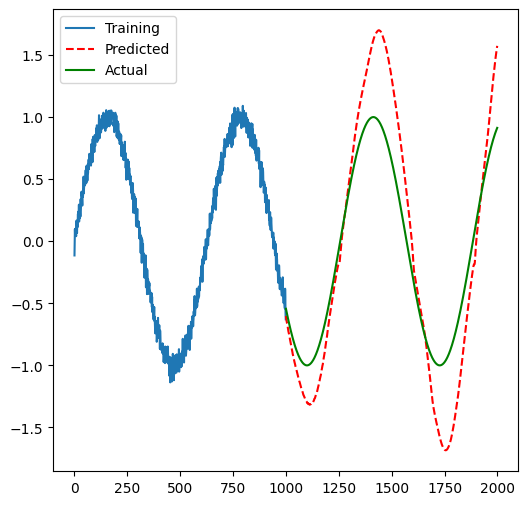

In [12]:
# Get a noisy sin wave
DATA_SIZE = 1000
x = np.sin(np.linspace(0, 10, DATA_SIZE))
x = x + np.random.normal(0, 0.05, DATA_SIZE)


# Create a dataset
seq_len = 200
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)])


# Training Loop
EPOCHS = 30
BATCH_SIZE = 8
LEARNING_RATE = 4.12e-5
model = ForecastingModel(seq_len, device)
model.to(device)
model.train()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")


# New Prediction Loop
FORCAST = 1000
model.eval()
for ff in range(FORCAST):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape(1, xx.shape[0]).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST], 'r--', label="Predicted")
plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 20, DATA_SIZE)), 'g-', label="Actual")
plt.legend()

In [13]:
# # A forcasting model
# class ForecastingModel(torch.nn.Module):
#     def __init__(self, 
#                  seq_len=200,
#                  embed_size = 16,
#                  nhead = 4,
#                  dim_feedforward = 2048,
#                  dropout = 0.1,
#                  conv1d_emb = True,
#                  conv1d_kernel_size = 3,
#                  device = device):
#         super(ForecastingModel, self).__init__()

#         # Set Class-level Parameters
#         self.device = device
#         self.conv1d_emb = conv1d_emb
#         self.conv1d_kernel_size = conv1d_kernel_size
#         self.seq_len = seq_len
#         self.embed_size = embed_size

#         # Input Embedding Component
#         if conv1d_emb:
#             if conv1d_kernel_size%2==0:
#                 raise Exception("conv1d_kernel_size must be an odd number to preserve dimensions.")
#             self.conv1d_padding = conv1d_kernel_size - 1
#             self.input_embedding  = nn.Conv1d(1, embed_size, kernel_size=conv1d_kernel_size)
#         else: self.input_embedding  = nn.Linear(1, embed_size)

#         # Positional Encoder Componet (See Code Copied from PyTorch Above)
#         self.position_encoder = PositionalEncoding(d_model=embed_size, 
#                                                    seq_len=seq_len,
#                                                    dropout=dropout)
        
#         # Transformer Encoder Layer Component
#         self.transformer_encoder = TransformerEncoderLayer(
#             d_model = embed_size,
#             nhead = nhead,
#             dim_feedforward = dim_feedforward,
#             dropout = dropout,
#             batch_first = True
#         )

#         # Regression Component
#         self.linear1 = nn.Linear(seq_len*embed_size, int(dim_feedforward))
#         self.linear2 = nn.Linear(int(dim_feedforward), int(dim_feedforward/2))
#         self.linear3 = nn.Linear(int(dim_feedforward/2), int(dim_feedforward/4))
#         self.linear4 = nn.Linear(int(dim_feedforward/4), int(dim_feedforward/16))
#         self.linear5 = nn.Linear(int(dim_feedforward/16), int(dim_feedforward/64))
#         self.outlayer = nn.Linear(int(dim_feedforward/64), 1)

#         # Basic Components
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)

#     # Model Forward Pass
#     def forward(self, x):
#         src_mask = self._generate_square_subsequent_mask()
#         src_mask.to(self.device)
#         if self.conv1d_emb: 
#             x = F.pad(x, (0, 0, self.conv1d_padding, 0), "constant", -1)
#             x = self.input_embedding(x.transpose(1, 2))
#             x = x.transpose(1, 2)
#         else: 
#             x = self.input_embedding(x)
#         x = self.position_encoder(x)
#         x = self.transformer_encoder(x, src_mask=src_mask).reshape((-1, self.seq_len*self.embed_size))
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.linear3(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.linear4(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.linear5(x)
#         x = self.relu(x)
#         return self.outlayer(x)
    
#     # Function Copied from PyTorch Library to create upper-triangular source mask
#     def _generate_square_subsequent_mask(self):
#         return torch.triu(
#             torch.full((self.seq_len, self.seq_len), float('-inf'), dtype=torch.float32, device=self.device),
#             diagonal=1,
#         )

In [14]:
# Get a noisy sin wave
# DATA_SIZE = 1000
# x = np.sin(np.linspace(0, 10, DATA_SIZE))
# x = x + np.random.normal(0, 0.05, DATA_SIZE)


# # Create a dataset
# seq_len = 200
# X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
# Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))


In [15]:
# # Training Loop
# EPOCHS = 30
# BATCH_SIZE = 1
# LEARNING_RATE = 2.2e-6
# model = ForecastingModel(seq_len, embed_size=8, nhead=2, dim_feedforward=1024, dropout=0, device=device)
# model.to(device)
# model.train()
# criterion = torch.nn.HuberLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# scheduler = ExponentialLR(optimizer, gamma=0.9)
# dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
# for epoch in range(EPOCHS):
#     for xx, yy in dataloader:
#         optimizer.zero_grad()
#         out = model(xx)
#         loss = criterion(out, yy)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()
#     print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")


In [16]:
# # Prediction Loop
# FORCAST = 1000
# model.eval()
# for ff in range(FORCAST):
#     xx = x[len(x)-seq_len:len(x)]
#     yy = model(torch.Tensor(xx).reshape(1, xx.shape[0], 1).to(device))
#     x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))


In [17]:
# # Plot Predictions
# fig = plt.figure(figsize=(6, 6))
# plt.plot(range(x[:DATA_SIZE].shape[0]), x[:DATA_SIZE], label="Training")
# plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), x[DATA_SIZE:DATA_SIZE+FORCAST], 'r--', label="Predicted")
# plt.plot(range(x[:DATA_SIZE].shape[0], x.shape[0]), np.sin(np.linspace(10, 20, DATA_SIZE)), 'g-', label="Actual")
# plt.legend()